# Questions

* Should I calculate business days since incident? or Total days?
* How to do timeseries?
  * Only predict a date based on the info that's happened BEFORE it?
  * Book by week? exact day of year? month?
 ---
* Could I make an EITHER/OR case?
  * First do a classifier for Compensate or Deny. If compensate, then do a Regression for HOW MUCH they'll get back?
  * I could also do models that ONLY take into account how much they asked for, IF I have enough data
* Why is my RF 410 MB?
* **I may be parsing 'ITEMS' wrong. Semicolon may indicate the various items missing**

### 1st simple model, "settle" or "compensate" I got 67.40% ROC!
### 2nd model, with claim_request_amount, roc_auc got 68.64%

# Next Steps
* Try a Rolling Window of 12 months to remove seasonality and see if there are changes from 2002 onward
* See if I can spot trends by day/week/month/holidays/weekends during the year

### *Is it an issue with 370 airports and 170 airlines?*
### I should consider dropping some of the claim_types and maybe other stuff too

# Feature engineer count of how many claims

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyspark

import datetime as dt

import tabula
import joblib

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE

In [3]:
dir = 'models/preliminary'

-----

-----

In [3]:
df = pd.read_pickle('./data/clean/clean_for_classifier_df.pkl')

In [4]:
col_names = ['claim_number', 'date_received', 'incident_date', 'airport_code', 'airport_name',
           'airline', 'claim_type', 'claim_site', 'item_category', 'close_amount', 'disposition']
           

In [5]:
df['binary_disposition'] = df['disposition']
df['binary_disposition'] = df['binary_disposition'].where(df['binary_disposition'] == 'Deny', other='Compensate')

# Change some text to make it more human readable
df.claim_site[df.claim_site == '-'] = 'Unknown'
df.claim_type[df.claim_type == '-'] = 'Unknown'

# Feature Engineering

### Count of items claimed

# TODO: Consider only using this for where claim_type is related to property.
df['num_items_or_incidents_claimed'] = df['item_category'].str.split(pat=';').apply(lambda x: len(x))
df['num_items_or_incidents_claimed'] = df['num_items_or_incidents_claimed'].where(df['claim_type'].str.contains('property', case=False) == True, other= 0)

### Time calculation
wait_period = df.date_received - df.incident_date
df['days_waited_to_file_claim'] = wait_period.dt.days

# Drop days where the 'date_received" was reported before 'incident_date'
df = df[df.days_waited_to_file_claim >= 0]

df.reset_index(inplace=True,drop=True)
df['bin_dispos_onehot'] = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/spencer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
# df['Week/Year_inc_date'] = df['incident_date'].apply(lambda x: "%d/%d" % (x.week, x.year))
# df['Week_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.week))
# df['Month_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.month))
# df['Year_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.year))

# df['Week_received'] = df['date_received'].apply(lambda x: "%d" % (x.week))
df['Month_received'] = df['date_received'].apply(lambda x: "%d" % (x.month))
# df['Year_received'] = df['date_received'].apply(lambda x: "%d" % (x.year))

In [7]:
## Figure out how to plot this shit. I want 12 months on the X axis, and then a bar for each month of the proportion of approved vs denied within each month (I think)

# TIME BREAKOUT COLUMNS

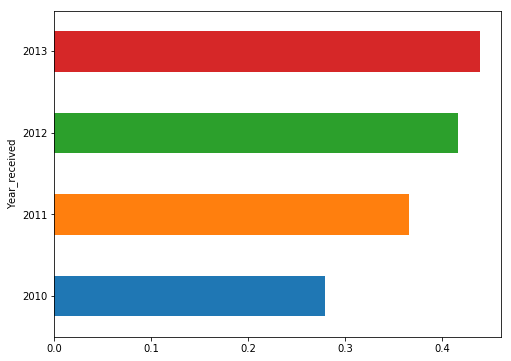

In [9]:
# df.groupby('Year_received').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6))

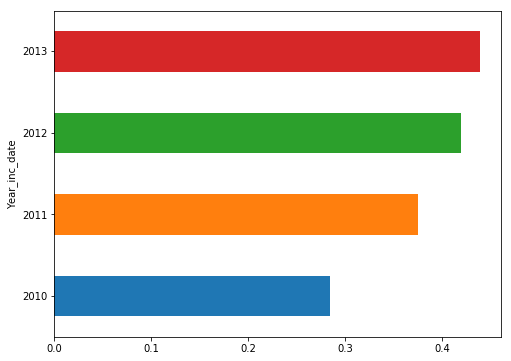

In [10]:
# df.groupby('Year_inc_date').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

In [254]:
X_df = df.drop(['binary_disposition', 'disposition', 
             'date_received', 'incident_date',
             'close_amount', 'num_items_or_incidents_claimed']
            ]
            , axis=1)
y = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

In [255]:
categorical = ['airport_code', 'airline', 'claim_type', 'claim_site', 'Month_received']
continuous =  ['days_waited_to_file_claim']

In [256]:
enc = OneHotEncoder(sparse=False)
onehotarray = enc.fit_transform(X_df[categorical])

ss = StandardScaler()
continuousarray = ss.fit_transform(X_df[continuous])

mlb = MultiLabelBinarizer(sparse_output=False)
onehot_itemcategories = mlb.fit_transform(X_df['item_category'].str.replace(' ','').str.split(pat=';'))

X = np.concatenate((onehotarray, continuousarray, onehot_itemcategories), axis=1)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Code to get pkled FIT shapes ready for Flask App

In [259]:
trans_dir = './web_app/stat_models/transformers'

enc = OneHotEncoder(sparse=False)
enc.fit(X_df[categorical])
joblib.dump(enc, f'{trans_dir}/onehotencode.joblib')
# onehotarray = enc.transform(X[categorical])

ss = StandardScaler()
ss.fit(X_df[continuous])
joblib.dump(ss, f'{trans_dir}/standardscaler.joblib')


mlb = MultiLabelBinarizer(sparse_output=False)
mlb.fit(X_df['item_category'].str.replace(' ','').str.split(pat=';'))
joblib.dump(mlb, f'{trans_dir}/item_category.joblib')

---

In [203]:
%%time
rf = RandomForestClassifier(random_state=42)

criterions = ['gini']#, 'entropy']
n_ests = [300]
m_depths = [25]
    
param_grid = dict(criterion=criterions, n_estimators=n_ests, max_depth=m_depths)

grid_rf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=10, n_jobs=4)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

y_pred = grid_rf.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.7033272641221381
{'criterion': 'gini', 'max_depth': 25, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.5969929111540007


In [242]:
savedir = 'models'
joblib.dump(grid_rf.best_estimator_, f'{savedir}/rf_months_12.03.2018.joblib',compress=9)

['models/rf_months_12.03.2018.joblib']

In [318]:
import catboost
from catboost import CatBoostClassifier

In [323]:
%%time
cboost = CatBoostClassifier(learning_rate=0.1, random_seed=42)
n_ests = [300]
m_depths = [30]
    
param_grid = dict(n_estimators=n_ests, max_depth=m_depths)

cat_clf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=10, n_jobs=4)

cat_clf.fit(X_train[-30000:], y_train[-30000:])

print(cat_clf.best_score_)
print(cat_clf.best_params_)
print(cat_clf.best_estimator_)

y_pred = cat_clf.predict(X_test[-30000:])
print(roc_auc_score(y_test[-30000:], y_pred[-30000:]))

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/ex

0.7000132331531255
{'max_depth': 30, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.5942895864007496
CPU times: user 1min 13s, sys: 2.38 s, total: 1min 16s
Wall time: 14min 28s


# TIME BREAKOUT COLUMNS

In [276]:
df['Week/Year_inc_date'] = df['incident_date'].apply(lambda x: "%d/%d" % (x.week, x.year))
df['Week_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.week))
df['Month_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.month))
df['Year_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.year))

df['Week_received'] = df['date_received'].apply(lambda x: "%d" % (x.week))
df['Month_received'] = df['date_received'].apply(lambda x: "%d" % (x.month))
df['Year_received'] = df['date_received'].apply(lambda x: "%d" % (x.year))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9a2761eac8>]],
      dtype=object)

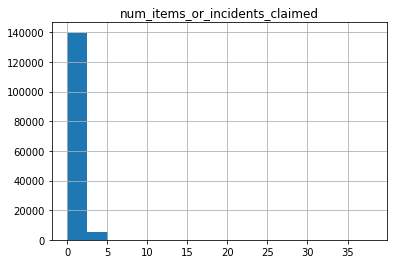

In [267]:
df.hist(column='num_items_or_incidents_claimed', bins=15)

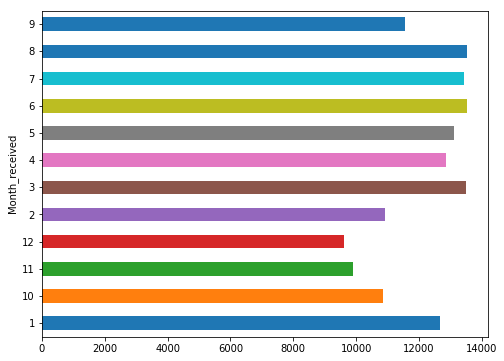

In [262]:
df.groupby('num_i').apply(lambda x: x.num_items_or_incidents_claimed.count()).plot(kind='barh', figsize=(8,6))

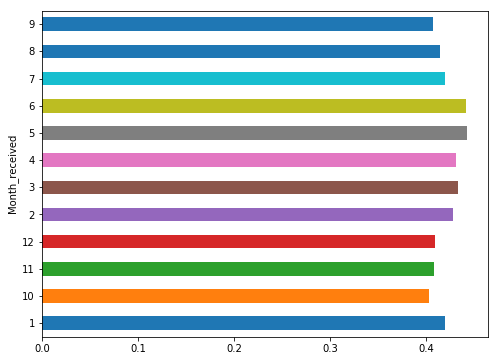

In [274]:
df.groupby('Month_received').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6), sort_columns=True)

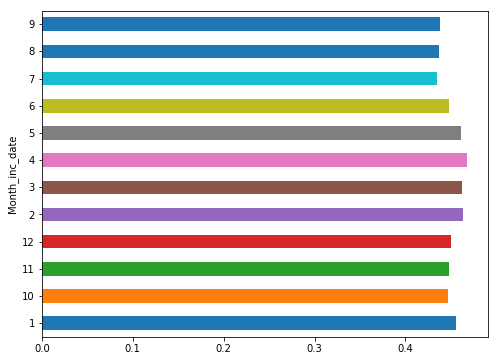

In [38]:
df.groupby('Month_inc_date').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

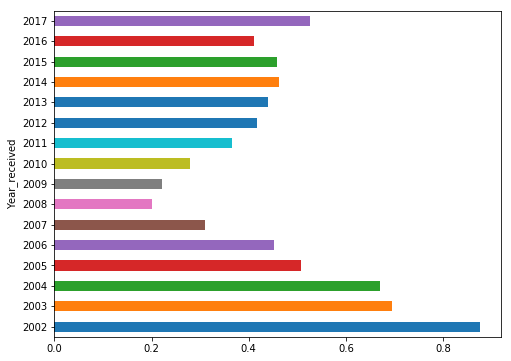

In [277]:
df.groupby('Year_received').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

In [93]:
# 
df[df.days_waited_to_file_claim < 180].hist(column='days_waited_to_file_claim',bins=180, figsize=(14,8))

AttributeError: 'NoneType' object has no attribute 'days_waited_to_file_claim'

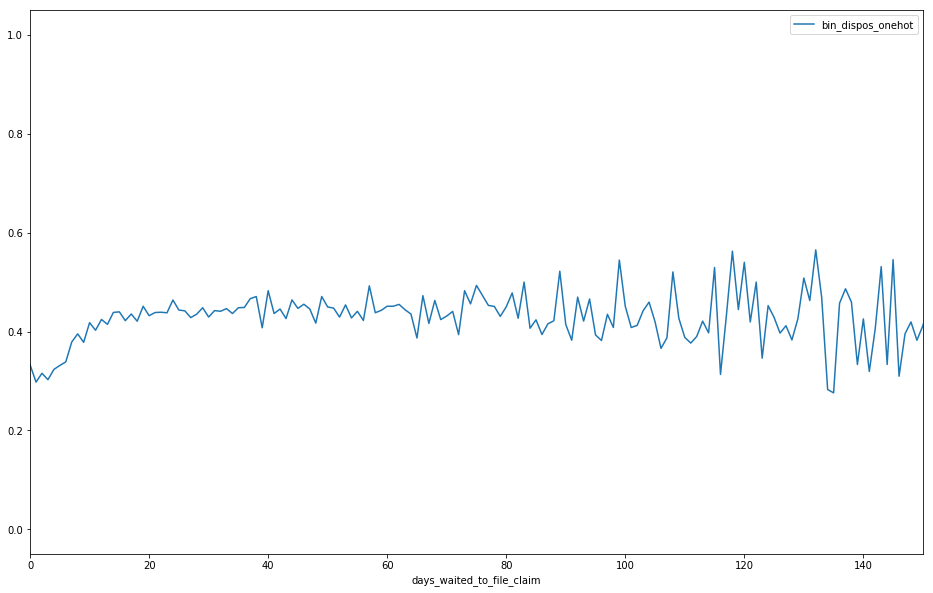

In [228]:
df.groupby('days_waited_to_file_claim').mean().plot(y='bin_dispos_onehot', xlim=(0,150),figsize=(16,10))

What are factors of play in driving results here?
What are most interesting ways to slice the data to see how the results may differ?
As a user of this model - what is the best ways I can use this information to make better decisions? (See above (file claim between 20-75). Can we get a tighter range on ideal filing time based on odds of fully/settled reimbursed?)

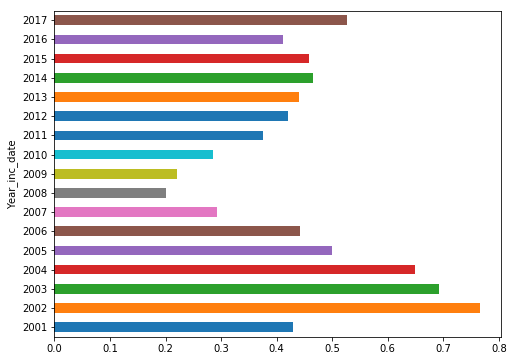

In [278]:
df.groupby('Year_inc_date').apply(lambda x: x.bin_dispos_onehot.sum() / x.bin_dispos_onehot.count()).plot(kind='barh', figsize=(8,6));

In [ ]:
# IT needs to be one entry in the master array. So like (1, 869)
# how do I get there? I need all the 869 features, and then I need to plug in the values as appropriate for the features I do have.

In [ ]:
# I think I need to take the big X with all the data, get its 869 feature array, then store the features for that.

# then with my example, I need to not fit_transform, but just transform it or something?!

# Explore with smaller data set

### Top 40 airports carried 80% of enplaning passengers in 2017

### Cutting list of airports down to the top 50 with most incidents still leaves 103011 out of 145421 observations (70.8%)
### From there, limiting to 14 out of 220 airlines gives us 89% of that (down to 90902 observations)

In [174]:
df[df.airport_code.isin(top_airports)].airport_code.value_counts().values

array([7051, 6950, 5242, 5169, 5126, 4654, 4526, 4032, 3989, 3722, 3553,
       3326, 3177, 3065, 3049, 3023, 2820, 2571, 2489, 2435, 2375, 2191,
       2136, 1630, 1495, 1485, 1418, 1269, 1156, 1147, 1097, 1055, 1052,
       1036, 1028,  977,  941,  902,  887,  862,  851,  828,  822,  766,
        728,  708,  554,  460,   21,   12])

In [171]:
# Create Dataset limited to top 40 airports and top 14 airlines
passengers = pd.read_pickle('./data/clean/usa2016-17-enplanements.pkl')

top_airports = passengers.airport_code.iloc[:40].values.tolist()
top_airlines = df.airline.value_counts()[:14].index.tolist()

smalldf = df[df.airport_code.isin(top_airports)]
smalldf = smalldf[smalldf.airline.isin(top_airlines)]

# Test model with new data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyspark

import datetime as dt

import tabula
import joblib

In [2]:
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 60)
pd.set_option('display.precision', 3)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import sklearn
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, cross_validate \
                                    ,cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,recall_score,precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.metrics import roc_curve, auc

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from imblearn.over_sampling import SMOTE

In [201]:
df = pd.read_pickle('./data/clean/clean_for_classifier_df.pkl')

In [202]:
col_names = ['claim_number', 'date_received', 'incident_date', 'airport_code', 'airport_name',
           'airline', 'claim_type', 'claim_site', 'item_category', 'close_amount', 'disposition']
           

In [203]:
# Create Dataset limited to top 40 airports and top 14 airlines
passengers = pd.read_pickle('./data/clean/usa2016-17-enplanements.pkl')

top_airports = list(passengers.airport_code.iloc[:40].unique())
top_airports.remove('MCI')
top_airports.remove('SFO')
top_airlines = df.airline.value_counts()[:14].index.tolist()


df = df[df.airport_code.isin(top_airports)]
df = df[df.airline.isin(top_airlines)]
df = df[(df.claim_site == 'Checked Baggage') | (df.claim_site == 'Checkpoint')]
df = df[(df.claim_type == 'PropertyLoss') | (df.claim_type == 'PropertyDamage')]

In [204]:
passengers = None
top_airports = None
top_airlines = None

In [205]:
df.dropna(inplace=True)

In [206]:
df['binary_disposition'] = df['disposition']
df['binary_disposition'] = df['binary_disposition'].where(df['binary_disposition'] == 'Deny', other='Compensate')

# Change some text to make it more human readable
df.claim_site[df.claim_site == '-'] = 'Unknown'
df.claim_type[df.claim_type == '-'] = 'Unknown'

# Feature Engineering

### Count of items claimed

# TODO: Consider only using this for where claim_type is related to property.
df['num_items_or_incidents_claimed'] = df['item_category'].str.split(pat=';').apply(lambda x: len(x))
df['num_items_or_incidents_claimed'] = df['num_items_or_incidents_claimed'].where(df['claim_type'].str.contains('property', case=False) == True, other= 0)

### Time calculation
wait_period = df.date_received - df.incident_date
df['days_waited_to_file_claim'] = wait_period.dt.days

# Drop days where the 'date_received" was reported before 'incident_date'
df = df[df.days_waited_to_file_claim >= 0]

df.reset_index(inplace=True,drop=True)
df['bin_dispos_onehot'] = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

In [207]:
# df['Week/Year_inc_date'] = df['incident_date'].apply(lambda x: "%d/%d" % (x.week, x.year))
# df['Week_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.week))
df['Month_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.month))
# df['Year_inc_date'] = df['incident_date'].apply(lambda x: "%d" % (x.year))

# df['Week_received'] = df['date_received'].apply(lambda x: "%d" % (x.week))
df['Month_received'] = df['date_received'].apply(lambda x: "%d" % (x.month))
# df['Year_received'] = df['date_received'].apply(lambda x: "%d" % (x.year))

In [208]:
df['squared_days_waited'] = df['days_waited_to_file_claim'].apply(lambda x: x**2)

In [209]:
X_small_df = df[['airport_code', 'airline', 'claim_type', 'claim_site', 'item_category', 'days_waited_to_file_claim', 'Month_received', 'Month_inc_date', 'squared_days_waited']]
y_small = df['binary_disposition'].apply(lambda x: 1 if x == 'Compensate' else 0)

In [210]:
categorical = ['airport_code', 'airline', 'claim_type', 'claim_site', 'Month_inc_date']
continuous =  ['days_waited_to_file_claim'] #, 'squared_days_waited']

In [172]:
enc = OneHotEncoder(sparse=False)
onehotarray = enc.fit_transform(X_small_df[categorical])

ss = StandardScaler()
continuousarray = ss.fit_transform(X_small_df[continuous])

mlb = MultiLabelBinarizer(sparse_output=False)
onehot_itemcategories = mlb.fit_transform(X_small_df['item_category'].str.replace(' ','').str.split(pat=';'))

X_small = np.concatenate((onehotarray, continuousarray, onehot_itemcategories), axis=1)

In [140]:
X_small.shape

(90193, 192)

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.3, random_state=42, stratify=y_small)

In [55]:
# Saving these inputs for flask app modelling
trans_dir = './web_app/stat_models/transformers'

enc = OneHotEncoder(sparse=False)
enc.fit(X_small_df[categorical])
joblib.dump(enc, f'{trans_dir}/onehotencode.joblib')

ss = StandardScaler()
ss.fit(X_small_df[continuous])
joblib.dump(ss, f'{trans_dir}/standardscaler.joblib')

mlb = MultiLabelBinarizer(sparse_output=False)
mlb.fit(X_small_df['item_category'].str.replace(' ','').str.split(pat=';'))
joblib.dump(mlb, f'{trans_dir}/item_category.joblib')

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


['./web_app/stat_models/transformers/item_category.joblib']

In [174]:
df = None

In [22]:
make_prediction

0.6290906065526554
{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.5
CPU times: user 57.1 s, sys: 264 ms, total: 57.3 s
Wall time: 57.3 s


In [142]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import SVC

In [20]:
%%time
rf = RandomForestClassifier(random_state=42)

criterions = ['gini']#, 'entropy']
n_ests = [300]
m_depths = [30]
param_grid = dict(criterion=criterions, n_estimators=n_ests, max_depth=m_depths)

grid_rf = GridSearchCV(rf, param_grid, scoring='roc_auc', cv=6, n_jobs=1)

grid_rf.fit(X_train, y_train)

print(grid_rf.best_score_)
print(grid_rf.best_params_)
print(grid_rf.best_estimator_)

y_pred = grid_rf.predict(X_test)
print(roc_auc_score(y_test, y_pred))

0.6916683486382915
{'criterion': 'gini', 'max_depth': 30, 'n_estimators': 300}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=30, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.6083105773516357
CPU times: user 8min 26s, sys: 312 ms, total: 8min 26s
Wall time: 8min 26s


In [21]:
savedir = 'models'
joblib.dump(grid_rf.best_estimator_, f'{savedir}/rf_subset_airports_airlines_12.04.2018.joblib',compress=9)

['models/rf_subset_airports_airlines_12.04.2018.joblib']

In [221]:
values

[('PropertyDamage', 14.80457116992758),
 ('Checked Baggage', 13.94616011307361),
 ('Computer&Accessories', 8.410017501846227),
 ('Jewelry&Watches', 5.663559364740651),
 ('days_waited_to_file_claim', 5.5206834680435675),
 ('Other', 4.464489824679669),
 ('Clothing', 4.4385487892889985),
 ('Cameras', 3.8674810023065485),
 ('Locks', 3.332997505939351),
 ('TravelAccessories', 3.080187885886824),
 ('Baggage/Cases/Purses', 2.7784295482581407),
 ('Cosmetics&Grooming', 2.7332875936039667),
 ('Checkpoint', 2.6733375875272127),
 ('LAS', 1.630675188861261),
 ('PropertyLoss', 1.284444392580773),
 ('PersonalElectronics', 1.1956155712803254),
 ('Watches', 1.1607889153218092),
 ('Alcoholicbeverages', 1.0889182128186303),
 ('EWR', 1.02832627650266),
 ('MP3Players-(iPods,etc)', 1.0056720621479067),
 ('Toys&Games', 1.0014493720052677),
 ('GPS', 0.9040522430295685),
 ('Handbags&Purses', 0.8758478929837927),
 ('Currency', 0.8754906347139596),
 ('JFK', 0.8667092021650332),
 ('AutomobileParts&Accessories', 0

In [96]:
feat_names = list(enc.categories_[0]) + list(enc.categories_[1]) + list(enc.categories_[2]) + list(enc.categories_[3]) + list(enc.categories_[4])+ list(X_small_df[continuous].columns) + list(mlb.classes_)

values = sorted(zip(feat_names, cat_clf.best_estimator_.feature_importances_), key=lambda x: x[1] * -1)

joblib.dump(values, './models/catboost_best_12.05_feature_importance_list')

['./models/catboost_best_12.05_feature_importance_list']

In [102]:
feat_names = list(enc.categories_[0]) + list(enc.categories_[1]) + list(enc.categories_[2]) + list(enc.categories_[3]) + list(enc.categories_[4])+ list(X_small_df[continuous].columns) + list(mlb.classes_)

values = sorted(zip(feat_names, grid_rf.best_estimator_.feature_importances_), key=lambda x: x[1] * -1)

joblib.dump(values, './models/rf_12.04_feature_importance_list')

In [18]:
%%time
gbclf = GradientBoostingClassifier(random_state=42)

n_ests = [300]
m_depths = [5, 10, 15]
learning_rates = [0.05, 0.1, 0.15]
param_grid = dict()#n_estimators=n_ests, max_depth=m_depths, learning_rate = learning_rates)

gb = GridSearchCV(gbclf, param_grid, scoring='roc_auc', cv=6, n_jobs=5)

gb.fit(X_train, y_train)

print(gb.best_score_)
# print(grid_rf.best_params_)
# print(grid_rf.best_estimator_)

y_pred = gb.predict(X_test)
print(roc_auc_score(y_test, y_pred))

savedir = 'models'
joblib.dump(gb.best_estimator_, f'{savedir}/gradboost_12.04.2018.joblib',compress=9)

0.6839737567441151
0.5794886547601418
CPU times: user 1min 48s, sys: 414 ms, total: 1min 48s
Wall time: 8min 13s


In [126]:
%%time
logitclf = LogisticRegression(random_state=42)

solvers = ['newton-cg', 'sag', 'lbfgs']
penalties = ['l2']
tols = [.001, .0001, .00001]
Cs = [0.5, 1.0, 1.5]
param_grid = dict(solver=solvers, penalty=penalties, tol=tols, C=Cs)

logit = GridSearchCV(logitclf, param_grid, scoring='roc_auc', cv=8, n_jobs=1)

logit.fit(X_train, y_train)

print(logit.best_score_)
# print(grid_rf.best_params_)
# print(grid_rf.best_estimator_)

y_pred = logit.predict(X_test)
print(roc_auc_score(y_test, y_pred))

savedir = 'models'
joblib.dump(logit.best_estimator_, f'{savedir}/logit_12.04.2018.joblib',compress=9)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_ite

0.6731556467229697
0.5960707825108541
CPU times: user 1h 13min 14s, sys: 1min 11s, total: 1h 14min 26s
Wall time: 26min 54s


In [123]:
%%time
bNBclf = BernoulliNB()

solvers = ['newton-cg', 'sag', 'lbfgs']
penalties = ['l2']
n_ests = [300]
m_depths = [30]
param_grid = dict()

bNB = GridSearchCV(bNBclf, param_grid, scoring='roc_auc', cv=8, n_jobs=1)

bNB.fit(X_train, y_train)

print(bNB.best_score_)
# print(grid_rf.best_params_)
# print(grid_rf.best_estimator_)

y_pred = bNB.predict(X_test)
print(roc_auc_score(y_test, y_pred))

savedir = 'models'
joblib.dump(bNB.best_estimator_, f'{savedir}/bernoulliNB_12.04.2018.joblib',compress=9)

0.6422614422937925
0.5849968847221777
CPU times: user 8.91 s, sys: 1.28 s, total: 10.2 s
Wall time: 2.68 s


In [19]:
%%time
SVCclf = SVC(random_state=42, gamma='auto')

kernels = [#'linear', 
           #'poly',
           #'sigmoid', 
           'rbf']
Cs = [5, 10, 15]
tols = [0.0001, 0.001, 0.01]
param_grid = dict(kernel=kernels)#, tol=tols, C=Cs)

SVC = GridSearchCV(SVCclf, param_grid, scoring='roc_auc', cv=8, n_jobs=4)

SVC.fit(X_train, y_train)

print(SVC.best_score_)
# print(grid_rf.best_params_)
# print(grid_rf.best_estimator_)

y_pred = SVC.predict(X_test)
print(roc_auc_score(y_test, y_pred))

savedir = 'models'
joblib.dump(SVC.best_estimator_, f'{savedir}/supportvector_12.04.2018.joblib',compress=9)

/home/spencer/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.6580844464200435
0.5566937910955249
CPU times: user 25min 8s, sys: 367 ms, total: 25min 9s
Wall time: 2h 7min 41s


In [22]:
%%time
exclf = ExtraTreesClassifier(random_state=42)

criterions = ['gini']#, 'entropy']
n_ests = [300]
m_depths = [30] #, 30, 40]
param_grid = dict(criterion=criterions, n_estimators=n_ests, max_depth=m_depths)

extra = GridSearchCV(exclf, param_grid, scoring='roc_auc', cv=8, n_jobs=5)

extra.fit(X_train, y_train)

print(extra.best_score_)
# print(grid_rf.best_params_)
# print(grid_rf.best_estimator_)

y_pred = extra.predict(X_test)
print(roc_auc_score(y_test, y_pred))

savedir = 'models'
joblib.dump(extra.best_estimator_, f'{savedir}/extratrees_12.04.2018.joblib',compress=9)

0.68361139641582
0.6011070003410419
CPU times: user 3min 4s, sys: 420 ms, total: 3min 4s
Wall time: 8min 5s


In [136]:
import catboost
from catboost import CatBoostClassifier

In [177]:
%%time
cboost = CatBoostClassifier(silent=True, one_hot_max_size=5, random_seed=42)
    
param_grid = dict() # n_estimators=n_ests)

cat_clf = GridSearchCV(cboost, param_grid, scoring='roc_auc', cv=8, n_jobs=5)

cat_clf.fit(X_train, y_train)

print(cat_clf.best_score_)
print(cat_clf.best_params_)
print(cat_clf.best_estimator_)

y_pred = cat_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))


savedir = 'models'
joblib.dump(cat_clf.best_estimator_, f'{savedir}/catboost_month_incident_oh5_12.06.2018.joblib',compress=3)

0.7022735521377326
{}
0.6278820646943781
CPU times: user 3min 47s, sys: 6.84 s, total: 3min 53s
Wall time: 5min 12s


In [182]:
%%time
cboost = CatBoostClassifier(silent=True, random_seed=42)
    
param_grid = dict() # n_estimators=n_ests)

cat_clf = GridSearchCV(cboost, param_grid, scoring='roc_auc', cv=8, n_jobs=5)

cat_clf.fit(X_train, y_train)

print(cat_clf.best_score_)
print(cat_clf.best_params_)
print(cat_clf.best_estimator_)

y_pred = cat_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))


savedir = 'models'
joblib.dump(cat_clf.best_estimator_, f'{savedir}/catboost_month_incident_12.06.2018.joblib',compress=3)

0.7022735521377326
{}
0.6278820646943781
CPU times: user 3min 46s, sys: 7.67 s, total: 3min 54s
Wall time: 5min 46s


In [160]:
%%time
cboost = CatBoostClassifier(silent=True, random_seed=42)
    
param_grid = dict() # n_estimators=n_ests)

cat_clf = GridSearchCV(cboost, param_grid, scoring='roc_auc', cv=8, n_jobs=5)

cat_clf.fit(X_train, y_train)

print(cat_clf.best_score_)
print(cat_clf.best_params_)
print(cat_clf.best_estimator_)

y_pred = cat_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))


savedir = 'models'
joblib.dump(cat_clf.best_estimator_, f'{savedir}/catboost_month_inc_and_squared_days_12.06.2018.joblib',compress=9)

0.7017768352354733
{}
0.6276856711426504
CPU times: user 3min 16s, sys: 4.89 s, total: 3min 21s
Wall time: 4min 14s


In [161]:
%%time
cboost = CatBoostClassifier(silent=True, one_hot_max_size=200, random_seed=42)
    
param_grid = dict() # n_estimators=n_ests)

cat_clf = GridSearchCV(cboost, param_grid, scoring='roc_auc', cv=8, n_jobs=5)

cat_clf.fit(X_train, y_train)

print(cat_clf.best_score_)
print(cat_clf.best_params_)
print(cat_clf.best_estimator_)

y_pred = cat_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))


savedir = 'models'
joblib.dump(cat_clf.best_estimator_, f'{savedir}/catboost_month_inc_and_squared_days_tweaked_12.06.2018.joblib',compress=9)

0.7017768352354733
{}
0.6276856711426504
CPU times: user 3min 49s, sys: 7.37 s, total: 3min 57s
Wall time: 5min 16s


In [183]:
example = {
  'airport_code': 'SEA',  # str
  'airline': 'Delta Air Lines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Clothing',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_inc_date': '1'  # int (1-12)
}


def make_prediction(features):
    '''
    :param features: dictionary like 'example' above
    :return: 2 pair dict of binary outcome (compensate and not compensate) and the probablity
    '''
    X = pd.DataFrame(data=features, index=[0])

    categorical = ['airport_code', 'airline', 'claim_type', 'claim_site', 'Month_inc_date']
    continuous = ['days_waited_to_file_claim']

    trans_dir = './web_app/stat_models/transformers'
    enc = joblib.load(f'{trans_dir}/onehotencode.joblib')
    onehotarray = enc.transform(X[categorical])

    ss = joblib.load(f'{trans_dir}/standardscaler.joblib')
    continuousarray = ss.transform(X[continuous])

    mlb = joblib.load(f'{trans_dir}/item_category.joblib')
    onehot_itemcategories = mlb.transform(X['item_category'].str.replace(' ', '').str.split(pat=';'))

    X = np.concatenate((onehotarray, continuousarray, onehot_itemcategories), axis=1)

    prob_receive_compensation = cat_clf.predict_proba(X)[0, 1]

    result = {
        'compensation': int(prob_receive_compensation > 0.5),
        'prob_receive_compensation': prob_receive_compensation
    }
    return prob_receive_compensation

In [ ]:
SEA, Delta, Damage, Checkpoint
 ('Computer&Accessories', 67),
 ('Jewelry&Watches', 69),
 ('Clothing', 75),
 ('Other', 78),
 ('Cameras', 63),
 ('Locks', 52),
 ('Baggage/Cases/Purses', 83),
 ('Cosmetics&Grooming', 72),
 ('Furniture', 72)

In [ ]:
67, 69, 75, 78, 63, 52, 83, 72, 72

In [ ]:
DFW, UAL, Lost, Checked Baggage
 ('Computer&Accessories', 15),
 ('Jewelry&Watches', 23),
 ('Clothing', 40),
 ('Other', 41),
 ('Cameras', 27),
 ('Locks', 56),
 ('Baggage/Cases/Purses', 28),
 ('Cosmetics&Grooming', 35),
 ('Furniture', 34)

In [242]:
example = {
  'airport_code': 'DFW',  # str
  'airline': 'UAL',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checked Baggage',  # str
  'item_category': 'Computer&Accessories',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_inc_date': '1'  # int (1-12)
}
make_prediction(example)

0.15482768369413913

In [185]:
import warnings
warnings.filterwarnings('ignore')

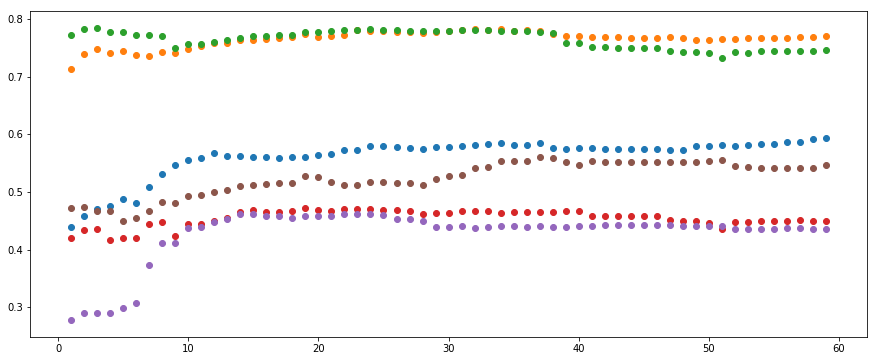

In [190]:
example = {
  'airport_code': 'SEA',  # str
  'airline': 'Delta Air Lines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Clothing',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_inc_date': '1'  # int (1-12)
}

period = range(1,60)

el1 = []
for i in period:
    example['days_waited_to_file_claim'] = i
    el1.append(make_prediction(example))

example = {
  'airport_code': 'JFK',  # str
  'airline': 'Southwest Airlines',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Clothing',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_inc_date': '10'  # int (1-12)
}
el2 = []
for i in period:
    example['days_waited_to_file_claim'] = i
    el2.append(make_prediction(example))

example = {
  'airport_code': 'ORD',  # str
  'airline': 'UAL',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Jewelry',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_inc_date': '11'  # int (1-12)
}
el3 = []
for i in period:
    example['days_waited_to_file_claim'] = i
    el3.append(make_prediction(example))

example = {
  'airport_code': 'ORD',  # str
  'airline': 'UAL',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checked Baggage',  # str
  'item_category': 'Jewelry',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_inc_date': '11'  # int (1-12)
}
el4 = []
for i in period:
    example['days_waited_to_file_claim'] = i
    el4.append(make_prediction(example))

example = {
  'airport_code': 'LAX',  # str
  'airline': 'American Airlines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checked Baggage',  # str
  'item_category': 'Computer',  # str
  'days_waited_to_file_claim': 30,  # int
  'Month_inc_date': '6'  # int (1-12)
}
el5 = []
for i in period:
    example['days_waited_to_file_claim'] = i
    el5.append(make_prediction(example))

example = {
  'airport_code': 'PDX',  # str
  'airline': 'Alaska Airlines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Purse',  # str
  'days_waited_to_file_claim': 5000,  # int
  'Month_inc_date': '3'  # int (1-12)
}
el6 = []
for i in period:
    example['days_waited_to_file_claim'] = i
    el6.append(make_prediction(example))

fig, ax = plt.subplots(figsize = (15,6))
ax.scatter(x=period, y=el1)
ax.scatter(x=period, y=el2)
ax.scatter(x=period, y=el3)
ax.scatter(x=period, y=el4)
ax.scatter(x=period, y=el5)
ax.scatter(x=period, y=el6)

In [198]:
X_small_df.head()


,airport_code,airline,claim_type,claim_site,item_category,days_waited_to_file_claim,Month_received,Month_inc_date,squared_days_waited
0,LAS,UAL,PropertyLoss,Checked Baggage,Clothing,37,11,10,1369
1,LAX,American Airlines,PropertyDamage,Checkpoint,Computer & Accessories,51,11,9,2601
2,MIA,American Airlines,PropertyLoss,Checked Baggage,Baggage/Cases/Purses; Clothing,161,10,5,25921
3,PHL,Southwest Airlines,PropertyLoss,Checked Baggage,Currency,8,10,10,64
4,IAD,UAL,PropertyLoss,Checked Baggage,Food & Drink,11,10,10,121


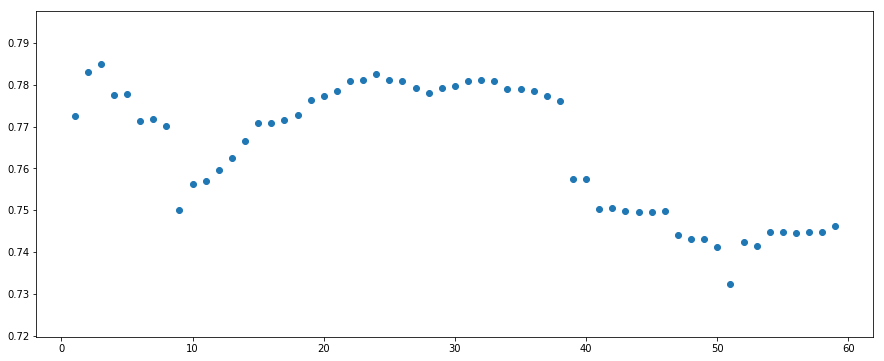

In [243]:
fig, ax = plt.subplots(figsize = (15,6))
ax.scatter(x=period, y=el3)


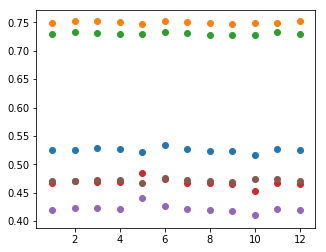

In [123]:
example = {
  'airport_code': 'SEA',  # str
  'airline': 'Delta Air Lines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Clothing',  # str
  'days_waited_to_file_claim': 20,  # int
  'Month_received': '1'  # int (1-12)
}
el1 = []
for i in range(1,13):
    example['Month_received'] = str(i)
    el1.append(make_prediction(example))

example = {
  'airport_code': 'JFK',  # str
  'airline': 'Southwest Airlines',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Clothing',  # str
  'days_waited_to_file_claim': 20,  # int
  'Month_received': '10'  # int (1-12)
}
el2 = []
for i in range(1,13):
    example['Month_received'] = str(i)
    el2.append(make_prediction(example))

example = {
  'airport_code': 'ORD',  # str
  'airline': 'UAL',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Jewelry',  # str
  'days_waited_to_file_claim': 20,  # int
  'Month_received': '11'  # int (1-12)
}
el3 = []
for i in range(1,13):
    example['Month_received'] = str(i)
    el3.append(make_prediction(example))

example = {
  'airport_code': 'ORD',  # str
  'airline': 'UAL',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checked Baggage',  # str
  'item_category': 'Jewelry',  # str
  'days_waited_to_file_claim': 20,  # int
  'Month_received': '11'  # int (1-12)
}
el4 = []
for i in range(1,13):
    example['Month_received'] = str(i)
    el4.append(make_prediction(example))

example = {
  'airport_code': 'LAX',  # str
  'airline': 'American Airlines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checked Baggage',  # str
  'item_category': 'Computer',  # str
  'days_waited_to_file_claim': 20,  # int
  'Month_received': '6'  # int (1-12)
}
el5 = []
for i in range(1,13):
    example['Month_received'] = str(i)
    el5.append(make_prediction(example))

example = {
  'airport_code': 'PDX',  # str
  'airline': 'Alaska Airlines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Purse',  # str
  'days_waited_to_file_claim': 20,  # int
  'Month_received': '3'  # int (1-12)
}
el6 = []
for i in range(1,13):
    example['Month_received'] = str(i)
    el6.append(make_prediction(example))

fig, ax = plt.subplots(figsize = (5,4))
ax.scatter(x=range(1,13), y=el1)
ax.scatter(x=range(1,13), y=el2)
ax.scatter(x=range(1,13), y=el3)
ax.scatter(x=range(1,13), y=el4)
ax.scatter(x=range(1,13), y=el5)
ax.scatter(x=range(1,13), y=el6)

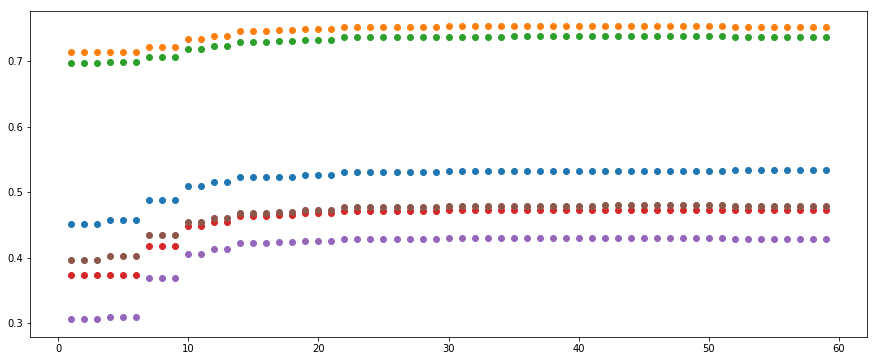

In [124]:
example = {
  'airport_code': 'SEA',  # str
  'airline': 'Delta Air Lines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Clothing',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_received': '1'  # int (1-12)
}
el1 = []
for i in range(1,60):
    example['days_waited_to_file_claim'] = i
    el1.append(make_prediction(example))

example = {
  'airport_code': 'JFK',  # str
  'airline': 'Southwest Airlines',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Clothing',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_received': '10'  # int (1-12)
}
el2 = []
for i in range(1,60):
    example['days_waited_to_file_claim'] = i
    el2.append(make_prediction(example))

example = {
  'airport_code': 'ORD',  # str
  'airline': 'UAL',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Jewelry',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_received': '11'  # int (1-12)
}
el3 = []
for i in range(1,60):
    example['days_waited_to_file_claim'] = i
    el3.append(make_prediction(example))

example = {
  'airport_code': 'ORD',  # str
  'airline': 'UAL',    # str
  'claim_type': 'PropertyDamage',    # str
  'claim_site': 'Checked Baggage',  # str
  'item_category': 'Jewelry',  # str
  'days_waited_to_file_claim': 7,  # int
  'Month_received': '11'  # int (1-12)
}
el4 = []
for i in range(1,60):
    example['days_waited_to_file_claim'] = i
    el4.append(make_prediction(example))

example = {
  'airport_code': 'LAX',  # str
  'airline': 'American Airlines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checked Baggage',  # str
  'item_category': 'Computer',  # str
  'days_waited_to_file_claim': 30,  # int
  'Month_received': '6'  # int (1-12)
}
el5 = []
for i in range(1,60):
    example['days_waited_to_file_claim'] = i
    el5.append(make_prediction(example))

example = {
  'airport_code': 'PDX',  # str
  'airline': 'Alaska Airlines',    # str
  'claim_type': 'PropertyLoss',    # str
  'claim_site': 'Checkpoint',  # str
  'item_category': 'Purse',  # str
  'days_waited_to_file_claim': 5000,  # int
  'Month_received': '3'  # int (1-12)
}
el6 = []
for i in range(1,60):
    example['days_waited_to_file_claim'] = i
    el6.append(make_prediction(example))

fig, ax = plt.subplots(figsize = (15,6))
ax.scatter(x=range(1,60), y=el1)
ax.scatter(x=range(1,60), y=el2)
ax.scatter(x=range(1,60), y=el3)
ax.scatter(x=range(1,60), y=el4)
ax.scatter(x=range(1,60), y=el5)
ax.scatter(x=range(1,60), y=el6)

In [43]:
import xgboost
from xgboost import XGBClassifier

In [44]:
%%time
xgb = XGBClassifier(silent=False, random_seed=42)

nests = [100, 300, 500]
lrates=[.02, .05]
colsample_bytrees = [0.5, 1]
subsamples = [0.3, 0.8]
scale_pos_weights = [0.5, 1]

param_grid = dict(learning_rate=lrates, n_estimators=nests, colsample_bytree=colsample_bytrees, subsample=subsamples, scale_pos_weight=scale_pos_weights)

xgb_clf = GridSearchCV(xgb, param_grid, scoring='roc_auc', cv=8, n_jobs=5)

xgb_clf.fit(X_train, y_train)

print(xgb_clf.best_score_)
print(xgb_clf.best_params_)
print(xgb_clf.best_estimator_)

y_pred = xgb_clf.predict(X_test)
print(roc_auc_score(y_test, y_pred))


savedir = 'models'
joblib.dump(xgb_clf.best_estimator_, f'{savedir}/xgb_12.05.2018.joblib',compress=9)

[17:12:41] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:12:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:12:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:12:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:12:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:12:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:12:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:12:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[17:12:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_

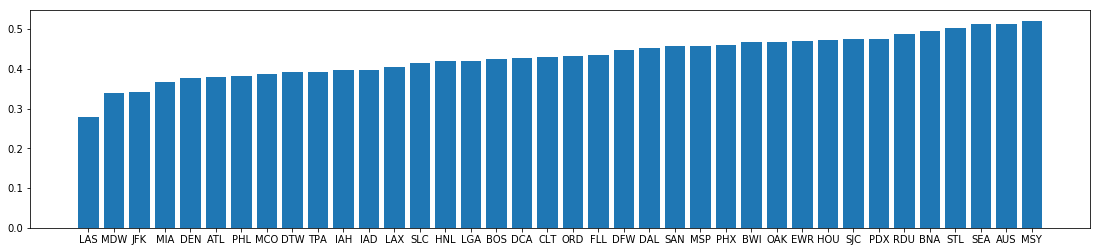

In [220]:
ser = df.groupby(['airport_code']).bin_dispos_onehot.mean().sort_values()
fig, ax = plt.subplots(figsize=(19, 4))
ax.bar(x=ser.index, height=ser.values);

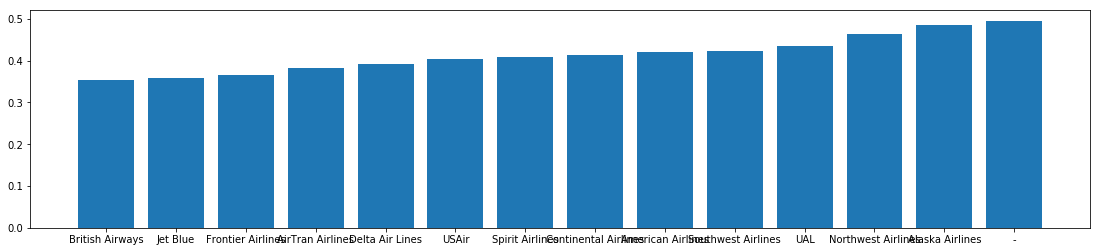

In [215]:
ser2 = df.groupby(['airline']).bin_dispos_onehot.mean().sort_values()
fig, ax = plt.subplots(figsize=(19, 4))
ax.bar(x=ser2.index, height=ser2.values);

In [204]:
df.head()

,date_received,incident_date,airport_code,airline,claim_type,claim_site,close_amount,disposition,item_category,binary_disposition,num_items_or_incidents_claimed,days_waited_to_file_claim,bin_dispos_onehot,Month_received
0,2017-11-28,2017-10-22 00:00:00,LAS,UAL,PropertyLoss,Checked Baggage,90.000,Settle,Clothing,Compensate,1,37,1,11
1,2017-11-20,2017-09-29 12:20:00,LAX,American Airlines,PropertyDamage,Checkpoint,485.550,Settle,Computer & Accessories,Compensate,1,51,1,11
2,2017-10-25,2017-05-17 00:00:00,MIA,American Airlines,PropertyLoss,Checked Baggage,65.000,Approve in Full,Baggage/Cases/Purses; Clothing,Compensate,2,161,1,10
3,2017-10-23,2017-10-15 00:00:00,PHL,Southwest Airlines,PropertyLoss,Checked Baggage,0.000,Deny,Currency,Deny,1,8,0,10
4,2017-10-19,2017-10-07 16:30:00,IAD,UAL,PropertyLoss,Checked Baggage,0.000,Deny,Food & Drink,Deny,1,11,0,10


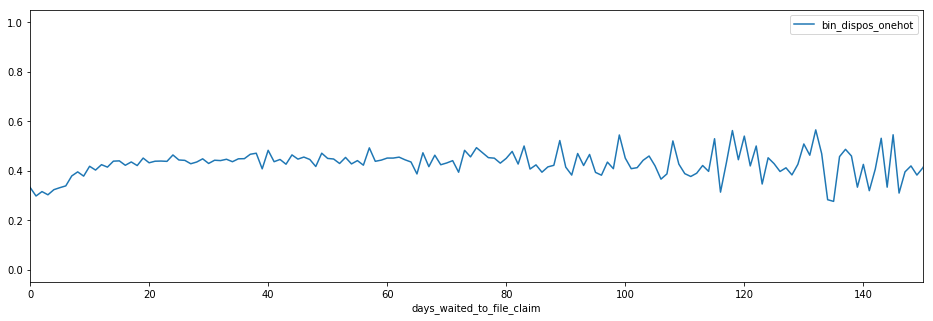

In [252]:
df.groupby('days_waited_to_file_claim').mean().plot(y='bin_dispos_onehot', xlim=(0,150),figsize=(16,5));

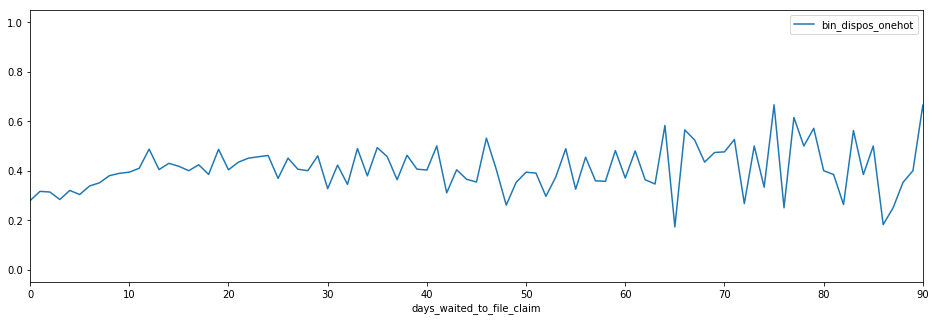

In [241]:
df[df.Month_inc_date == '7'].groupby('days_waited_to_file_claim').mean().plot(y='bin_dispos_onehot', xlim=(0,90),figsize=(16,5));

In [227]:
df.groupby(['Month_inc_date']).bin_dispos_onehot.mean().sort_values(ascending=False)

Month_inc_date
4    0.440
3    0.431
2    0.428
5    0.427
6    0.421
1    0.417
12   0.412
10   0.408
11   0.405
8    0.403
9    0.401
7    0.398
Name: bin_dispos_onehot, dtype: float64

In [225]:
df.groupby(['Month_received']).bin_dispos_onehot.mean().sort_values(ascending=False)

Month_received
5    0.435
6    0.434
4    0.427
3    0.424
2    0.421
7    0.415
8    0.412
1    0.410
11   0.406
12   0.405
9    0.400
10   0.398
Name: bin_dispos_onehot, dtype: float64

In [218]:
df[(df.claim_site == 'Checkpoint') & (df.claim_type == 'PropertyDamage')].groupby(['airport_code', 'claim_type', 'claim_site']).bin_dispos_onehot.mean().sort_values(ascending=False)

airport_code  claim_type      claim_site
STL           PropertyDamage  Checkpoint   0.812
BWI           PropertyDamage  Checkpoint   0.808
ORD           PropertyDamage  Checkpoint   0.800
BNA           PropertyDamage  Checkpoint   0.791
EWR           PropertyDamage  Checkpoint   0.790
SJC           PropertyDamage  Checkpoint   0.786
JFK           PropertyDamage  Checkpoint   0.778
MCO           PropertyDamage  Checkpoint   0.777
AUS           PropertyDamage  Checkpoint   0.760
BOS           PropertyDamage  Checkpoint   0.759
SEA           PropertyDamage  Checkpoint   0.757
RDU           PropertyDamage  Checkpoint   0.757
PHX           PropertyDamage  Checkpoint   0.752
PDX           PropertyDamage  Checkpoint   0.748
LGA           PropertyDamage  Checkpoint   0.744
MSP           PropertyDamage  Checkpoint   0.744
DFW           PropertyDamage  Checkpoint   0.733
DCA           PropertyDamage  Checkpoint   0.729
HOU           PropertyDamage  Checkpoint   0.723
SAN           PropertyDamage

In [213]:
df.head()

,date_received,incident_date,airport_code,airline,claim_type,claim_site,close_amount,disposition,item_category,binary_disposition,num_items_or_incidents_claimed,days_waited_to_file_claim,bin_dispos_onehot,Month_received,Month_inc_date,squared_days_waited
0,2017-11-28,2017-10-22 00:00:00,LAS,UAL,PropertyLoss,Checked Baggage,90.000,Settle,Clothing,Compensate,1,37,1,11,10,1369
1,2017-11-20,2017-09-29 12:20:00,LAX,American Airlines,PropertyDamage,Checkpoint,485.550,Settle,Computer & Accessories,Compensate,1,51,1,11,9,2601
2,2017-10-25,2017-05-17 00:00:00,MIA,American Airlines,PropertyLoss,Checked Baggage,65.000,Approve in Full,Baggage/Cases/Purses; Clothing,Compensate,2,161,1,10,5,25921
3,2017-10-23,2017-10-15 00:00:00,PHL,Southwest Airlines,PropertyLoss,Checked Baggage,0.000,Deny,Currency,Deny,1,8,0,10,10,64
4,2017-10-19,2017-10-07 16:30:00,IAD,UAL,PropertyLoss,Checked Baggage,0.000,Deny,Food & Drink,Deny,1,11,0,10,10,121


In [212]:
df[(df.claim_site == 'Checkpoint')].groupby(['claim_type', 'claim_site']).bin_dispos_onehot.mean().sort_values(ascending=False)

claim_type      claim_site     
PropertyDamage  Checkpoint        0.722
                Checked Baggage   0.422
PropertyLoss    Checked Baggage   0.369
                Checkpoint        0.362
Name: bin_dispos_onehot, dtype: float64

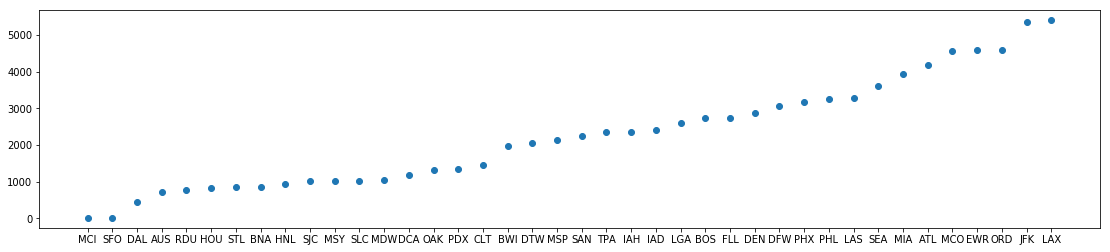

In [87]:
ser3 = df.groupby(['airport_code']).airport_code.count().sort_values()
fig, ax = plt.subplots(figsize=(19, 4))
ax.scatter(x=ser3.index, y=ser3.values);